# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [3]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.linear_model import LinearRegression

%matplotlib inline

Прочитаем исходные данные:

In [5]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB
None
             Well         Por        Perm          AI     Brittle         TOC  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean   100.500000   14.991150    4.330750    2.968850   48.161950    0.990450   
std     57.879185    2.971176    1.731014    0.566885   14.129455    0.481588   
min      1.000000    6.550000    1.130000    1.280000   10.940000   -0.190000   
25%     50.750000   12.912500    3.122500    2.547500  

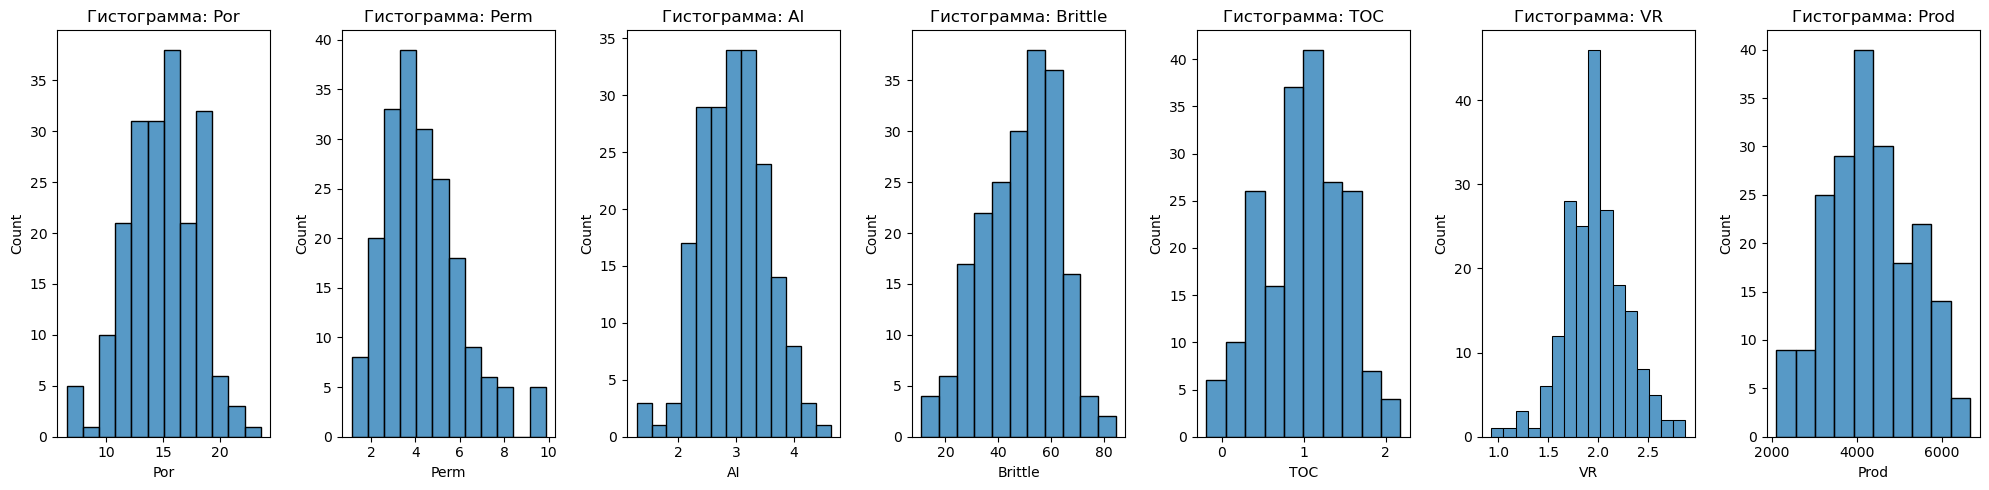

Парные графики


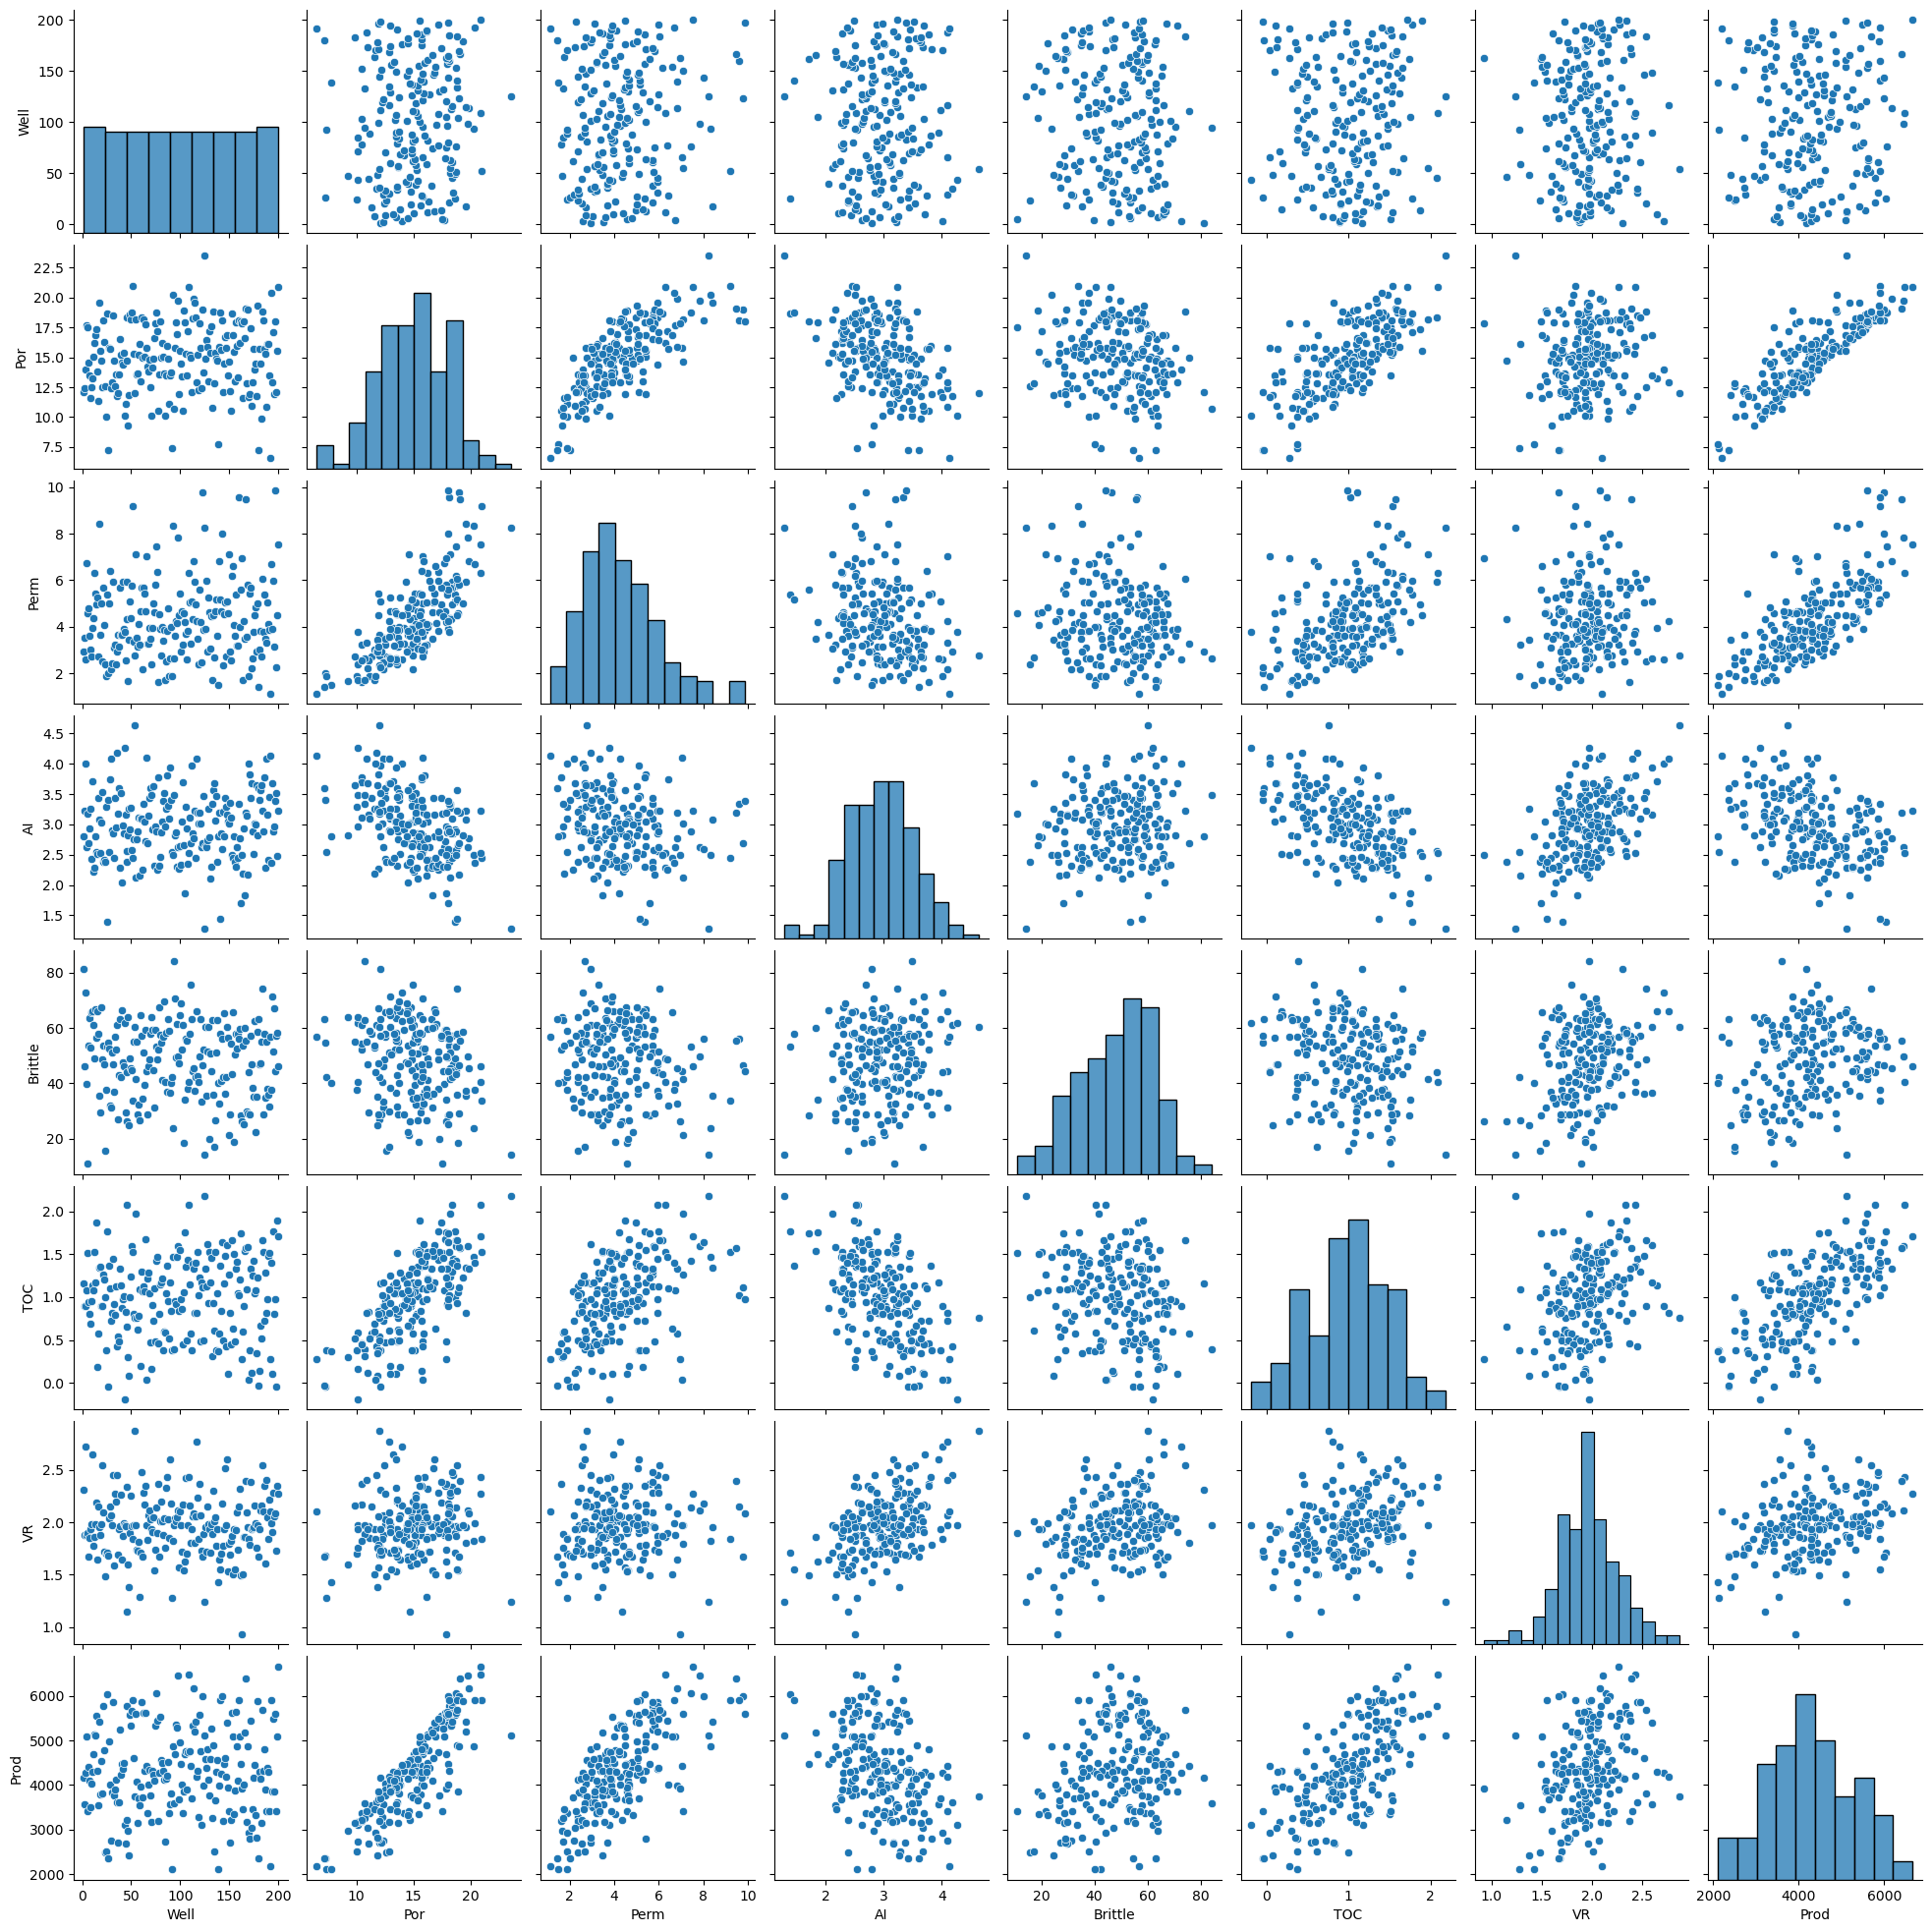

In [11]:
gaz_data = pd.DataFrame(data)

# Основная информация о данных, статистика
print(gaz_data.info())
print(gaz_data.describe())

# Гистограммы
plt.figure(figsize=(20, 5))
for i, column in enumerate(gaz_data.columns[1:], 1):
    plt.subplot(1, 7, i)
    sns.histplot(gaz_data[column])
    plt.title(f'Гистограмма: {column}')
plt.tight_layout()
plt.show()

# Парные графики 
print('Парные графики')
sns.pairplot(gaz_data)
plt.show()
## Выводы:
# Основная информация о данных: данные полностью заполнены, все данные - с плавающей точкой (кроме номера скважины)
# Минимальный TOC (процент углерода) - отрицаетельное значение, это странно.
# Гистограммы: нормальные, симметричные. в гитограмме Perm (проницаемость) есть выброс.
# Парные графики: на первый взгляд - линейная зависимость Por (пористости), Perm (проницаемость), TOC (проц углерода) и Prod (добыча газа).

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

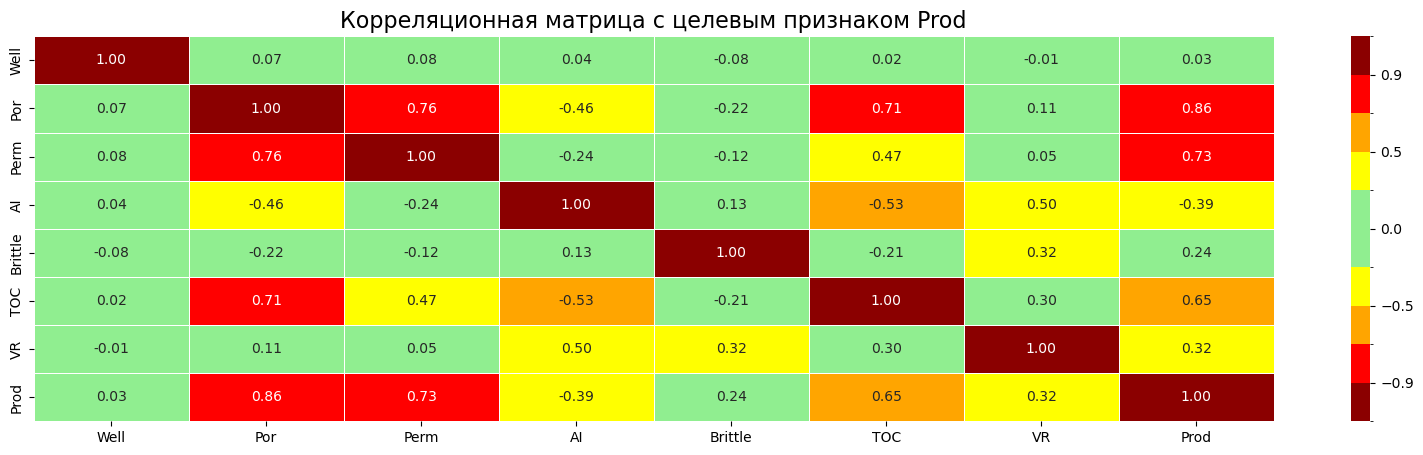

Well       0.026817
Por        0.861910
Perm       0.727426
AI        -0.390835
Brittle    0.237155
TOC        0.654445
VR         0.323182
Prod       1.000000
Name: Prod, dtype: float64
определитель матрицы: 0.0007299388072652082, ранг матрицы: 8


In [14]:
# корреляционная матрица
correlation = gaz_data.corr()
correlation_Prod = correlation['Prod']

# Диаграмма с поределенными границами
boundaries = [-1, -0.9, -0.7, -0.5, -0.3, 0, 0.3, 0.5, 0.7, 0.9, 1]
colors = ['darkred', 'red', 'orange', 'yellow', 'lightgreen', 'lightgreen', 'yellow', 'orange', 'red', 'darkred']  # Цвета для диапазонов
cmap = ListedColormap(colors) 
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
plt.figure(figsize=(20, 5))
heatmap = sns.heatmap(correlation, annot=True, cmap=cmap, fmt=".2f", linewidths=.5, norm=norm)
plt.title('Корреляционная матрица с целевым признаком Prod', fontsize=16)
plt.show()

# определитель и ранг
det = np.linalg.det(correlation)
rank = np.linalg.matrix_rank(correlation)
print (correlation_Prod)
print (f'определитель матрицы: {det}, ранг матрицы: {rank}')

> С переменной Prod (добыча газа) сильная связь с факторами Por (пористость) и Perm (проницаемость) средняя связь с TOC (процент углерода).
> Определитель матрицы близок к нулю (0.0007), матрица может быть плохо обусловленной.
> Ранг матрицы равен количеству признаков.
> Есть большие корреляции между данными (выделены на диаграмме красным), возможно наличие коллинераности в данных.
> Модель линейной регрессии по МНК в данном виде таблицы не применима, определитель близок к 0 и есть симптомы коллинераности.

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [18]:
# Выделение матрицы наблюдений X и вектора ответов y
X = gaz_data.drop(columns=['Well', 'Prod']).values  # Убираем индикатор скважины и целевую переменную
y = gaz_data['Prod'].values

# Добавление столбца единиц для свободного члена
X_intercept = np.column_stack((np.ones(X.shape[0]), X))

# Матричная формула МНК
beta = np.linalg.inv(X_intercept.T @ X_intercept) @ X_intercept.T @ y
print(beta)

# Создадим таблицу переменных с коэффициентами
# Имена переменных
feature_names = ['Intercept'] + list(gaz_data.columns[1:-1])  # 'Intercept' + названия признаков

# Создание DataFrame с коэффициентами
coefficients_df = pd.DataFrame({
    'Признаки': feature_names,
    'Коэффициенты': np.round(beta) # Округление до целого
})

print(f'\nПризнаки и коэффициенты до стадартизации\n{coefficients_df}')

def standartization (X, y):
    # стандартизируем векторы в столбцах матрицы X
    X_cent = X - X.mean(axis=0)
    X_st = X_cent/np.linalg.norm(X_cent, axis=0)
    # стандартизируем вектор целевой переменной y
    y_cent = y - y.mean()
    y_st = y_cent/np.linalg.norm(y_cent)
    return X_st, y_st

X_st, y_st = standartization (X, y)
# вычислим OLS-оценку для стандартизированных коэффициентов
beta_st=np.linalg.inv(X_st.T@X_st)@X_st.T@y_st
beta_st_df = pd.DataFrame(beta_st)
# Создадим таблицу переменных с коэффициентами
# Имена переменных
feature_names_st = list(gaz_data.columns[1:-1])  # названия признаков
# Создание DataFrame с коэффициентами после стадартизации
coefficients_df_st = pd.DataFrame({
    'Признаки': feature_names_st,
    'Коэффициенты': np.round(beta_st,3) # Округление до целого
})
print(f'\nПризнаки и коэффициенты после стадартизации\n{coefficients_df_st}')

[-1230.26203694   230.29581021   116.2280334   -363.73608557
    24.9966698    -77.43674242   783.18741348]

Признаки и коэффициенты до стадартизации
    Признаки  Коэффициенты
0  Intercept       -1230.0
1        Por         230.0
2       Perm         116.0
3         AI        -364.0
4    Brittle          25.0
5        TOC         -77.0
6         VR         783.0

Признаки и коэффициенты после стадартизации
  Признаки  Коэффициенты
0      Por         0.690
1     Perm         0.203
2       AI        -0.208
3  Brittle         0.356
4      TOC        -0.038
5       VR         0.237


> Пористость (Por) - коэффициент положительный, с увеличением пористости на 1 ожидаемая продуктивность скважины будет увеличиваться на 230.
> Проницаемость (Per) - коэффициент положительный, с увеличением проницаемости на 1 ожидаемая продуктивность скважины будет расти на 116.
> Вязкость (VR) -коэффициент положительный, с увеличением вязкости на 1 ожидаемая продуктивность скважины будет расти на 783.
> Негативные коэффициенты (AI, TOC) показывают факторы, которые могут снижать производительность.
> Стандартизованные данные показывают, что наибольший эффект на продуктивность скважины оказывет фактор Por (пористость).

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [22]:
## Расчет для скважины №106
# Параметры для скважины 106 (Удаляем номер скважины, вместо него добавляем 1 для свободного члена)
well_106_params = np.array([1, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42])

# Извлечение коэффициентов в массив
coefficients_values = coefficients_df['Коэффициенты'].values

# Расчет прогноза
prod_forecast_well_106 = np.dot(well_106_params, coefficients_values)

# Фактическая выработка для скважины 106
actual_production_well_106 = 4748.315024

# Расчет абсолютной ошибки
absolute_error_well_106 = np.abs(actual_production_well_106 - prod_forecast_well_106)

# Вывод результатов (а)
print(f'Прогноз выработки газа для скважины 106: {prod_forecast_well_106:.2f} млн куб. футов/день')
print(f'Абсолютная ошибка для скважины 106: {absolute_error_well_106:.2f} млн куб. футов/день')

## Расчет для всех скважин
# Расчет прогнозов для всех скважин
gaz_data['Prod_Forecast'] = np.dot(X_intercept, coefficients_values)

# Вычисляем абсолютные ошибки
gaz_data['Absolute_Error'] = np.abs(gaz_data['Prod'] - gaz_data['Prod_Forecast'])
print(f'\nПолученная таблица (3 строки) \n{gaz_data.head(3)}\n')

## Оценка качества модели - метрика MAPE (средняя абсолютная процентная ошибка)
mape = np.mean(np.abs((gaz_data['Prod'] - gaz_data['Prod_Forecast']) / gaz_data['Prod'])) * 100
print(f'Оценка качества модели - MAPE:     {mape:.2f}%')

# Оценка качества модели - метрика R2 (коэффициент детерминации)
R2 = 1 - (np.sum((gaz_data['Prod'] - gaz_data['Prod_Forecast']) ** 2) / np.sum((gaz_data['Prod'] - np.mean(gaz_data['Prod'])) ** 2))
print(f'Оценка качества модели - R2:       {(R2*100):.1f}%')

Прогноз выработки газа для скважины 106: 4717.06 млн куб. футов/день
Абсолютная ошибка для скважины 106: 31.26 млн куб. футов/день

Полученная таблица (3 строки) 
   Well    Por  Perm    AI  Brittle   TOC    VR         Prod  Prod_Forecast  \
0     1  12.08  2.92  2.80    81.40  1.16  2.31  4165.196191        4622.33   
1     2  12.38  3.53  3.22    46.17  0.89  1.88  3561.146205        3412.56   
2     3  14.02  2.59  4.01    72.80  0.89  2.72  4284.348574        4716.63   

   Absolute_Error  
0      457.133809  
1      148.586205  
2      432.281426  

Оценка качества модели - MAPE:     3.64%
Оценка качества модели - R2:       96.0%


> Абсолютная ошибка для скважины 106: 31.26 млн куб. футов/день.
> Для оценки модели выбрал метрики MAPE и R2.
> MAPE измеряет среднюю абсолютную процентную ошибку между предсказанными и фактическими значениями. Выражается в процентах и позволяет оценить, насколько хорошо модель предсказывает значения по сравнению с реальными данными.
> MAPE = 3.64% - низкий, модель хорошо прогнозирует.
> R2 измеряет долю вариации зависимой переменной, которая объясняется независимыми переменными в модели. Показывает, насколько хорошо модель объясняет данные.
> R2 = 96 %, что говорит о высокой предсказательной способности модели.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [26]:
# Создание DataFrame для корреляции, исключая 'Prod'
def integrated_table(correlation_Prod, coefficients_df):
    correlation_data = {
        'Признаки': correlation_Prod.index.drop('Prod'),  # Убираем 'Prod' из индексов
        'Корреляция': correlation_Prod.drop('Prod')  # Убираем значение для 'Prod'
}
    correlation_df = pd.DataFrame(correlation_data)

    # Объединение двух DataFrame по столбцу 'Признаки'
    comparison_df = pd.merge(correlation_df, coefficients_df, left_on='Признаки', right_on='Признаки', how='left')

    # Добавление колонки для определения противоречий
    def check_contradiction(row):
        if (row['Корреляция'] > 0 and row['Коэффициенты'] < 0) or (row['Корреляция'] < 0 and row['Коэффициенты'] > 0):
            return 'Противоречие'
        else:
            return 'Нет противоречия'

    comparison_df['Противоречие'] = comparison_df.apply(check_contradiction, axis=1)

    # Вывод таблицы сравнения
    return print(comparison_df[['Признаки', 'Корреляция', 'Коэффициенты', 'Противоречие']])

integrated_table(correlation_Prod, coefficients_df)

  Признаки  Корреляция  Коэффициенты      Противоречие
0     Well    0.026817           NaN  Нет противоречия
1      Por    0.861910         230.0  Нет противоречия
2     Perm    0.727426         116.0  Нет противоречия
3       AI   -0.390835        -364.0  Нет противоречия
4  Brittle    0.237155          25.0  Нет противоречия
5      TOC    0.654445         -77.0      Противоречие
6       VR    0.323182         783.0  Нет противоречия


>  По всем параметрам, кроме TOC, знак корелляции с Prod и знак коэффициента линейной регрессии совпадают.
>  По TOC - противоречие: корреляция - положительная (0.654445), коэффициент линейной регрессии отрицательный (-77.0).
>  Связано это, скорре всего с ошибкой измерения TOC. TOC - это процент органического углерода в дебите скважины, он не может быть отрицательным.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

Удаленные факторы: {'Prod_Forecast', 'Well', 'TOC', 'Absolute_Error', 'Perm'}

Новый датафрейм после удаления факторов:
      Por    AI  Brittle    VR         Prod
0  12.08  2.80    81.40  2.31  4165.196191
1  12.38  3.22    46.17  1.88  3561.146205
2  14.02  4.01    72.80  2.72  4284.348574
3  17.67  2.63    39.81  1.88  5098.680869
4  17.52  3.18    10.94  1.90  3406.132832


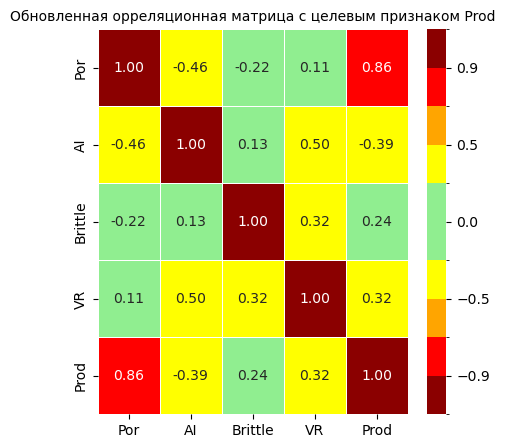


определитель матрицы: 0.020180673433452513, ранг матрицы: 5


Признаки и коэффициенты после удаления факторов: : 
    Признаки  Коэффициенты
0  Intercept       -1835.0
1        Por         293.0
2         AI        -200.0
3    Brittle          28.0
4         VR         517.0

  Признаки  Корреляция  Коэффициенты      Противоречие
0      Por    0.861910         293.0  Нет противоречия
1       AI   -0.390835        -200.0  Нет противоречия
2  Brittle    0.237155          28.0  Нет противоречия
3       VR    0.323182         517.0  Нет противоречия
Оценка качества модели - MAPE:     4.05%
Оценка качества модели - R2:       94.5%


In [30]:
# Устанавливаем порог для корреляции
correlation_threshold = 0.7
prod_correlation_threshold = 0.05

# Находим сильно коррелированные пары
to_drop = set()  # Множество для хранения столбцов, которые нужно удалить
# Итерируем по всем парам факторов
for i in range(len(correlation.columns)):
    for j in range(i):       
        if abs(correlation.iloc[i, j]) > correlation_threshold:
            # Если корреляция сильная, добавляем один из факторов в список на удаление
            colname = correlation.columns[i]
            to_drop.add(colname)
            to_drop.discard('Prod')
# Добавляем дополнительные факторы для удаления
additional_factors_to_drop = {'Absolute_Error', 'Prod_Forecast'}
to_drop.update(additional_factors_to_drop)
# Удаляем факторы с корреляцией с 'Prod' меньше 0.05
prod_correlation = correlation['Prod'].abs()  # Получаем абсолютные значения корреляции с 'Prod'
low_correlation_factors = prod_correlation[prod_correlation < prod_correlation_threshold].index.tolist()
to_drop.update(low_correlation_factors)
# Удаляем полученные факторы из датафрейма
gaz_data = gaz_data.drop(columns=to_drop)
# Выводим результаты удаления
print("Удаленные факторы:", to_drop)
print("\nНовый датафрейм после удаления факторов:\n", gaz_data.head())

# корреляционная матрица
correlation = gaz_data.corr()
correlation_Prod = correlation['Prod']

# Диаграмма с поределенными границами
boundaries = [-1, -0.9, -0.7, -0.5, -0.3, 0, 0.3, 0.5, 0.7, 0.9, 1]
colors = ['darkred', 'red', 'orange', 'yellow', 'lightgreen', 'lightgreen', 'yellow', 'orange', 'red', 'darkred']  # Цвета для диапазонов
cmap = ListedColormap(colors) 
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
plt.figure(figsize=(5, 5))
heatmap = sns.heatmap(correlation, annot=True, cmap=cmap, fmt=".2f", linewidths=.5, norm=norm)
plt.title('Обновленная орреляционная матрица с целевым признаком Prod', fontsize=10)
plt.show()

# определитель и ранг
det = np.linalg.det(correlation)
rank = np.linalg.matrix_rank(correlation)
print (f'\nопределитель матрицы: {det}, ранг матрицы: {rank}\n')

# ЛИНЕЙНАЯ РЕГРЕССИЯ
# Подготовка данных для линейной регрессии
X_red = gaz_data.drop(columns = ['Prod']).values
y_red = gaz_data['Prod'].values

# Добавление столбца единиц для свободного члена
X_intercept_red = np.c_[np.ones(X_red.shape[0]), X_red]

# Вычисление коэффициентов линейной регрессии
beta_red = np.linalg.inv(X_intercept_red.T @ X_intercept_red) @ X_intercept_red.T @ y_red

# ВИЗУАЛИЗАЦИЯ
# Создадим таблицу переменных с коэффициентами
# Имена переменных
feature_names_red = ['Intercept'] + list(gaz_data.columns[:-1])  # 'Intercept' + названия признаков
# Создание DataFrame с коэффициентами
coefficients_df_red = pd.DataFrame({
    'Признаки': feature_names_red,
    'Коэффициенты': np.round(beta_red) # Округление до целого
})
coefficients_values_red = coefficients_df_red['Коэффициенты'].values
# Вывод таблицы
print(f'\nПризнаки и коэффициенты после удаления факторов: : \n{coefficients_df_red}\n')

# Таблица противоречий
integrated_table(correlation_Prod, coefficients_df_red)

# Расчет прогнозов для всех скважин
gaz_data['Prod_Forecast_red'] = np.dot(X_intercept_red, coefficients_values_red)

# Вычисляем абсолютные ошибки
gaz_data['Absolute_Error_red'] = np.abs(gaz_data['Prod'] - gaz_data['Prod_Forecast_red'])

# Оценка качества модели - метрика MAPE (средняя абсолютная процентная ошибка)
mape = np.mean(np.abs((gaz_data['Prod'] - gaz_data['Prod_Forecast_red']) / gaz_data['Prod'])) * 100
print(f'Оценка качества модели - MAPE:     {mape:.2f}%')
# Оценка качества модели - метрика R2 (коэффициент детерминации)
R2 = 1 - (np.sum((gaz_data['Prod'] - gaz_data['Prod_Forecast_red']) ** 2) / np.sum((gaz_data['Prod'] - np.mean(gaz_data['Prod'])) ** 2))
print(f'Оценка качества модели - R2:       {(R2*100):.1f}%')

>  По всем параметрам знак корелляции и знак коэффициента линейной регрессии совпадают. Протворечий нет. Действия по приведению данных в соответсвие успешны. Определитель матрицы также лучше на несколько порядков.
> Метрики модели линейной регрессии. MAPE = 4.05% - низкий, модель хорошо прогнозирует. R2 = 94.5 %, что говорит о высокой предсказательной способности модели. Тем не менее, метрики немного ухудшились по сравнению с моделью регрессии без удаленных факторов. Возможно, это связано с тем что данные не стандартизованы.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [34]:

# Создание модели линейной регрессии
X = gaz_data.drop(columns = ['Prod', 'Prod_Forecast_red', 'Absolute_Error_red']).values
y = gaz_data['Prod'].values
model = LinearRegression()
# Обучение модели
model.fit(X, y)
# Прогноз для всего обучающего набора данных
y_pred = model.predict(X)

# DataFrame с коэффициентами
coefficients = pd.DataFrame({
    'Признаки': feature_names_red[1:],
    'Коэффициенты': np.round(model.coef_, 0) # Округление до целого
})

# Таблица с коэффициентами
print(f'\nПризнаки и коэффициенты после удаления факторов: : \n{coefficients}\n')
# Интерцепт (свободный член), округлённый до целого
print("Интерцепт:      ", np.round(model.intercept_, 0))
# Оценка качества модели - метрика MAPE (средняя абсолютная процентная ошибка)
mape = np.mean(np.abs((y - y_pred) / y) * 100)
print(f'\nОценка качества модели - MAPE:     {mape:.2f}%')
# Оценка качества модели - метрика R2 (коэффициент детерминации)
R2 = model.score(X, y)
print(f'Оценка качества модели - R2:       {(R2*100):.1f}%')



Признаки и коэффициенты после удаления факторов: : 
  Признаки  Коэффициенты
0      Por         293.0
1       AI        -200.0
2  Brittle          28.0
3       VR         517.0

Интерцепт:       -1835.0

Оценка качества модели - MAPE:     4.04%
Оценка качества модели - R2:       94.5%


> Интесепт и коэффициенты не изменились, по сравнению с ручным методом.
> MAPE и R2 также не изменились.
> Главное отличие - в трудоемкости формирования модели, с помощью LinearRegression библиотеки sklearn это значительно быстрее и проще.
> Для дальнейшего анализа в качестве метрики используем только MAPE (средняя абсолютная процентная ошибка).

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [60]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_percentage_error, make_scorer

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [64]:
def polynomial_regression_sk(X, y, k):
    X = StandardScaler().fit_transform(X)
    X_poly = PolynomialFeatures(degree=k, include_bias=False).fit_transform(X)
    cv_results = cross_validate(LinearRegression().fit(X_poly, y), 
                                X_poly, y, scoring='neg_mean_absolute_percentage_error', 
                                cv=5, return_train_score=True
                               )
    return X_poly, cv_results

# Подготовка данных
A = gaz_data.drop(columns=['Prod', 'Prod_Forecast_red', 'Absolute_Error_red']).values
y = gaz_data['Prod'].values
k = 3

# Оценка модели и вывод результатов
X_poly, cv_results = polynomial_regression_sk(A, y, k)
MAPE_ts_linear = -cv_results['train_score'].mean() * 100
MAPE_vs_linear = -cv_results['test_score'].mean() * 100
print(f'Количество факторов после генерации полиномиальных признаков: {X_poly.shape[1]}')
print("MAPE на тренировочных фолдах: {:.2f} %".format(MAPE_ts_linear))
print("MAPE на валидационных фолдах: {:.2f} %".format(MAPE_vs_linear))

Количество факторов после генерации полиномиальных признаков: 34
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


> MAPE значително луxше чем на модели LinearRegression без PolynomialFeatures (1,77% и 2,68% на тренировочных и валидационных фолдах против 4.04% на классической LinearRegression.
> Использовано 34 полиномиальных признака (степень 3) против 4 признаков классической LinearRegression. Это улучшило результаты, при этом модель не переобучена.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [69]:
def lasso_sk(X, y, k):
    from sklearn.model_selection import GridSearchCV
    X = StandardScaler().fit_transform(X)
    X_poly = PolynomialFeatures(degree=k, include_bias=False).fit_transform(X)
    # Задаем диапазон значений alpha для поиска
    param_grid = {'alpha': np.logspace(-2, 0, 50)}  # от 0.01 до 10
    grid_search = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='r2')
    grid_search.fit(X_poly, y)
    best_alpha = grid_search.best_params_['alpha'] # Наилучший найденный коэффициент регуляризации
    cv_results = cross_validate(Lasso(alpha=best_alpha, max_iter=10000), 
                                X_poly, y, scoring='neg_mean_absolute_percentage_error', 
                                cv=5, return_train_score=True
                               )
    return X_poly, cv_results, best_alpha

# Подготовка данных
A = gaz_data.drop(columns=['Prod', 'Prod_Forecast_red', 'Absolute_Error_red']).values
y = gaz_data['Prod'].values
k = 3

# Оценка модели и вывод результатов
X_poly, cv_results, best_alpha = lasso_sk(A, y, k)
MAPE_ts_lasso = -cv_results['train_score'].mean() * 100
MAPE_vs_lasso = -cv_results['test_score'].mean() * 100
best_alpha_lasso = best_alpha
print(f'Количество факторов после генерации полиномиальных признаков: {X_poly.shape[1]}')
print("Лучший коэффициент регуляризации: {:.2f}".format(best_alpha_lasso))
print("MAPE на тренировочных фолдах: {:.2f} %".format(MAPE_ts_lasso))
print("MAPE на валидационных фолдах: {:.2f} %".format(MAPE_vs_lasso))

Количество факторов после генерации полиномиальных признаков: 34
Лучший коэффициент регуляризации: 1.00
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.48 %


> Для подбора гипер параметров выбран метод GridSearchCV библиотеки scikit-learn, метод осуществляет перебор характеристик в заданных границах, в данном случае 50 значений в границе от 0.01 до 10.
> Подобран коэффициент регуляции (альфа) равный 1.
> MAPE на тренировочных фолдах L1-регуляризации (Lasso) совпадает с метрикой в модели LinearRegression 1,77%.
> MAPE на валидационных фолдахи L1-регуляризации (Lasso) 2,48%, меньше чем в модели LinearRegression (2,68%).
> Лучший коэффициент регуляции (альфа) равен 1.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [72]:
def ridge_sk(X, y, k):
    from sklearn.model_selection import GridSearchCV
    X = StandardScaler().fit_transform(X)
    X_poly = PolynomialFeatures(degree=k, include_bias=False).fit_transform(X)
    # Задаем диапазон значений alpha для поиска
    param_grid = {'alpha': np.logspace(-2, 0, 50)}  # от 0.01 до 10
    grid_search = GridSearchCV(Ridge(max_iter=10000), param_grid, cv=5, scoring='r2')
    grid_search.fit(X_poly, y)
    best_alpha = grid_search.best_params_['alpha'] # Наилучший найденный коэффициент регуляризации
    cv_results = cross_validate(Ridge(alpha=best_alpha, max_iter=10000), 
                                X_poly, y, scoring='neg_mean_absolute_percentage_error', 
                                cv=5, return_train_score=True
                               )
    return X_poly, cv_results, best_alpha

# Подготовка данных
A = gaz_data.drop(columns=['Prod', 'Prod_Forecast_red', 'Absolute_Error_red']).values
y = gaz_data['Prod'].values
k = 3

# Оценка модели и вывод результатов
X_poly, cv_results, best_alpha = ridge_sk(A, y, k)
MAPE_ts_ridge = -cv_results['train_score'].mean() * 100
MAPE_vs_ridge = -cv_results['test_score'].mean() * 100
best_alpha_ridge = best_alpha
print(f'Количество факторов после генерации полиномиальных признаков: {X_poly.shape[1]}')
print("Лучший коэффициент регуляризации: {:.2f}".format(best_alpha_ridge))
print("MAPE на тренировочных фолдах: {:.2f} %".format(MAPE_ts_ridge))
print("MAPE на валидационных фолдах: {:.2f} %".format(MAPE_vs_ridge))

Количество факторов после генерации полиномиальных признаков: 34
Лучший коэффициент регуляризации: 0.83
MAPE на тренировочных фолдах: 1.81 %
MAPE на валидационных фолдах: 2.70 %


> MAPE на тренировочных фолдах L2-регуляризации (регуляризация Тихонова) 1.81 %, это больше че в модели Lasso (1,77%).
> MAPE на валидационных фолдахи L2-регуляризации 2,70%, это больше че в модели Lasso (2,48%).
> Лучший коэффициент регуляции (альфа) равен 0.83 (метод GridSearchCV).
> Результаты хуже чем в модели L1-регуляризации.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [77]:
def ElasticNet_sk(X, y, k):
    from sklearn.model_selection import GridSearchCV
    X = StandardScaler().fit_transform(X)
    X_poly = PolynomialFeatures(degree=k, include_bias=False).fit_transform(X)
    # Задаем диапазон значений alpha и l1_ratio для поиска
    param_grid = {
        'alpha': np.logspace(-2, 0, 50),
        'l1_ratio': [0.1, 0.5, 0.9, 1.0]
    }
    grid_search = GridSearchCV(ElasticNet(max_iter=10000), param_grid, cv=5, scoring='r2')
    grid_search.fit(X_poly, y)
    best_alpha = grid_search.best_params_['alpha']  # Наилучший найденный alpha
    best_l1_ratio = grid_search.best_params_['l1_ratio']  # Наилучший коэффициент l1_ratio
    cv_results = cross_validate(ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000), 
                                X_poly, y, scoring='neg_mean_absolute_percentage_error', 
                                cv=5, return_train_score=True
                               )
    return X_poly, cv_results, best_alpha, best_l1_ratio

# Подготовка данных
A = gaz_data.drop(columns=['Prod', 'Prod_Forecast_red', 'Absolute_Error_red']).values
y = gaz_data['Prod'].values
k = 3

# Оценка модели и вывод результатов
X_poly, cv_results, best_alpha, best_l1_ratio = ElasticNet_sk(A, y, k)
MAPE_ts_elastic = -cv_results['train_score'].mean() * 100
MAPE_vs_elastic = -cv_results['test_score'].mean() * 100
best_alpha_elastic = best_alpha
best_l1_ratio_elastic = best_l1_ratio
print(f'Количество факторов после генерации полиномиальных признаков: {X_poly.shape[1]}')
print("Лучший коэффициент регуляризации: {:.2f}".format(best_alpha_elastic))
print("Лучший коэффициент l1_ratio: {:.2f}".format(best_l1_ratio_elastic))
print("MAPE на тренировочных фолдах: {:.2f} %".format(MAPE_ts_elastic))
print("MAPE на валидационных фолдах: {:.2f} %".format(MAPE_vs_elastic))

Количество факторов после генерации полиномиальных признаков: 34
Лучший коэффициент регуляризации: 1.00
Лучший коэффициент l1_ratio: 1.00
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.48 %


> Метод GridSearchCV определил альфа = 1, l1_ratio = 1. Это значит, что метод предлагает полностью отключить L2-регуляризацию. 
> MAPE на тренировочных и валидационных фолдах L1+L2-регуляризации совпадает с L1 регуляризацией.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

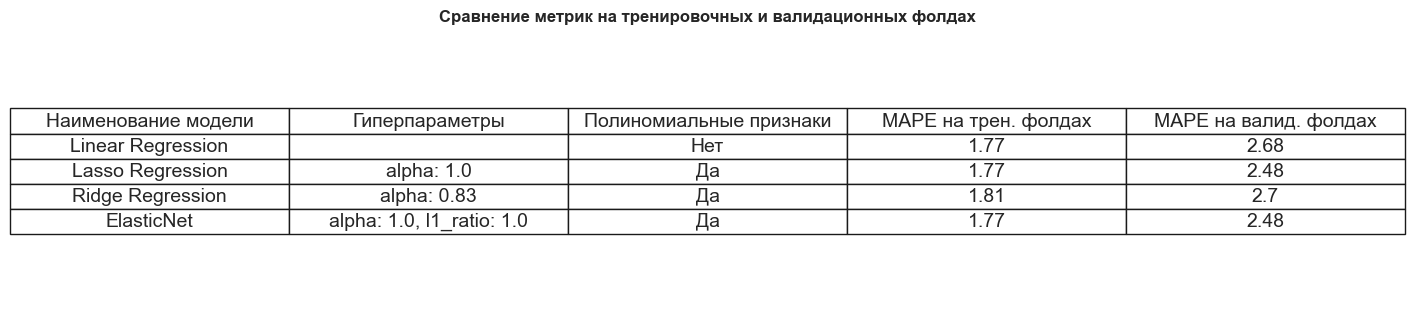

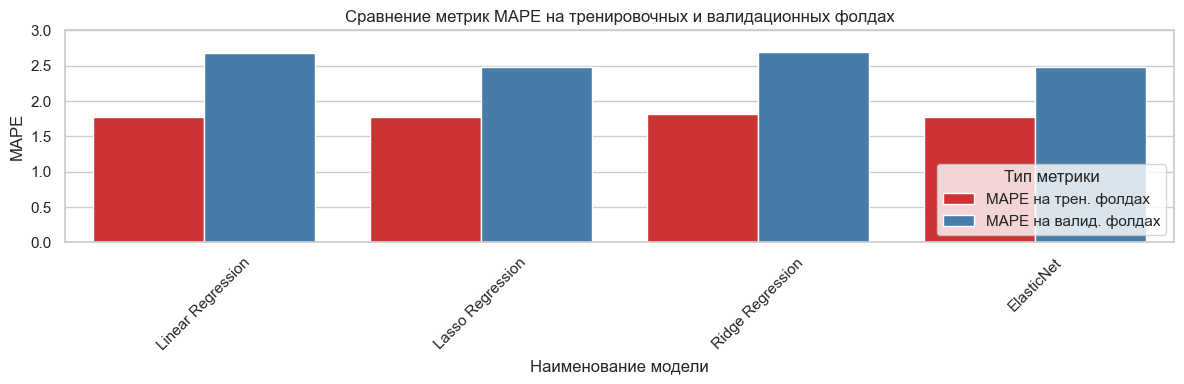

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создадим данные для таблицы
# Создадим данные для таблицы
data = {
    'Наименование модели': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'ElasticNet'],
    'Гиперпараметры': [
        "", 
        f'alpha: {round(best_alpha_lasso, 2)}', 
        f'alpha: {round(best_alpha_ridge, 2)}',  
        f'alpha: {round(best_alpha_elastic, 2)}, l1_ratio: {round(best_l1_ratio_elastic, 2)}'
    ],
    'Полиномиальные признаки': ['Нет', 'Да', 'Да', 'Да'],
    'MAPE на трен. фолдах': [MAPE_ts_linear, MAPE_ts_lasso, MAPE_ts_ridge, MAPE_ts_elastic],
    'MAPE на валид. фолдах': [MAPE_vs_linear, MAPE_vs_lasso, MAPE_vs_ridge, MAPE_vs_elastic],
}


# Создание DataFrame
df = pd.DataFrame(data)
df['MAPE на трен. фолдах'] = (df['MAPE на трен. фолдах']).round(2)
df['MAPE на валид. фолдах'] = (df['MAPE на валид. фолдах']).round(2)

# Преобразование данных для построения графика
df_melted = df.melt(id_vars='Наименование модели', 
                    value_vars=['MAPE на трен. фолдах', 'MAPE на валид. фолдах'], 
                    var_name='Тип метрики', 
                    value_name='Значение')


# Создание таблицы
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

# Установка заголовка
plt.text(0.5, 1.0, 'Сравнение метрик на тренировочных и валидационных фолдах',
         ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transAxes)

# Установка размера шрифта для таблицы
table.auto_set_font_size(False)
table.scale(1.5, 1.5)
for key, cell in table.get_celld().items():
    cell.set_fontsize(14)  
    cell.set_text_props(ha='center', va='center')  
plt.show()


# Настройка стиля графиков
sns.set(style="whitegrid")
plt.figure(figsize=(12, 4))
sns.barplot(x='Наименование модели', y='Значение', hue='Тип метрики', data=df_melted, palette='Set1')
plt.title('Сравнение метрик MAPE на тренировочных и валидационных фолдах')
plt.ylabel('MAPE')
plt.xticks(rotation=45)
plt.legend(title='Тип метрики')
plt.tight_layout() 
plt.ylim(0, 3)
plt.legend(title='Тип метрики', loc='lower right')
plt.show()

> Наилучший результат с точки зрения качества и с точки зрения непереробученности показала модель Lasso.
> При тесте модели ElasticNet метод подбора гиперпараметров GridSearchCV определил  l1_ratio = 1. Это значит, что метод предлагает полностью импользовать модель Lasso.
> Модель Lasso показала лучшие результаты по MAPE как на тренировочниых (1,77%), так и на валидационных фолдах (2,48%).
> Предлагаем Василию, владельцу Газ-Таз-Ваз-Нефть, для прогноза продуктивности газовых скважин использовать модель Lаsso.